# Difficulty Classification

Goal:
* Classify a task for a given student as too difficult or ok.

Data:
- Robotanist, order and times of solved tasks
- proxy for "too difficult" = spent more than 10 minutes


Notes:
- The threshold of 10 minutes is arbitraty. It was chosen as it's easily interpretable even for users and because it makes the problem highly unbalanced (there are only about 5% of difficult labels), which makes this project a good training of how to deal with this common scenario.


Usage:
- hard recommendation: filter/lock too difficult tasks
- soft recommendation: indicate too difficult task (e.g. via red color or coarse time predictions)
- set challenge level (e.g. 5m if ok, 15m for too difficult)


Extensions:
* Ideally, the same methods should be usable in scenario where  explicit user information (qualitative data) about perceived difficulty are available.
* Second classifier for too easy tasks (e.g. < 1 minute).
* Use content-based features (e.g. length of the optimal solution, number of world-features).

In [25]:
%matplotlib inline
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score
from sklearn import svm, feature_selection
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# Data

In [2]:
ordering = pd.read_csv('../data/robotanik/user_time_ordering.csv', index_col='Login')
# Make task IDs integers (from string labels).
ordering.columns = map(int, ordering.columns)
# Remove tasks with not enough data.
ordering = ordering.dropna(axis=1, thresh=40)
ordering.head()

,635,636,637,638,639,640,641,642,643,644,...,1124,1125,1401,1402,1403,1404,1704,1705,1706,1707
Login,,,,,,,,,,,,,,,,,,,,,
U1,1.0,2.0,13.0,5.0,NaN,9.0,NaN,NaN,NaN,10.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U2,1.0,2.0,4.0,3.0,5.0,6.0,9.0,10.0,8.0,11.0,...,37.0,43.0,57.0,NaN,NaN,NaN,58.0,59.0,60.0,61.0
U4,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U5,1.0,2.0,3.0,4.0,16.0,5.0,15.0,NaN,11.0,13.0,...,21.0,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U6,1.0,2.0,3.0,7.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
times = pd.read_csv('../data/robotanik/user_time.csv', index_col='Login')
# Make task IDs integers (from string labels).
times.columns = map(int, times.columns)
# Infere "true labels" (too difficult case)
TOO_DIFFICULT_THRESHOLD_MINUTES = 10
labels = times > 60 * TOO_DIFFICULT_THRESHOLD_MINUTES
#labels.head()
# We will work with log times.
times = times.applymap(np.log)
times.head()

,635,636,637,638,639,640,641,642,643,644,...,1402,1403,1404,1405,1406,1407,1704,1705,1706,1707
Login,,,,,,,,,,,,,,,,,,,,,
U1,3.218876,2.564949,2.639057,3.637586,NaN,6.129050,NaN,NaN,NaN,4.882802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U2,2.302585,1.609438,3.891820,2.944439,4.521789,3.135494,4.043051,3.688879,3.737670,5.351858,...,NaN,NaN,NaN,NaN,NaN,NaN,5.220356,4.727388,3.583519,4.290459
U4,3.258097,1.791759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U5,3.951244,3.663562,3.218876,2.944439,5.897154,3.218876,4.595120,NaN,4.025352,3.828641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U6,4.219508,2.995732,3.465736,2.890372,NaN,3.737670,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


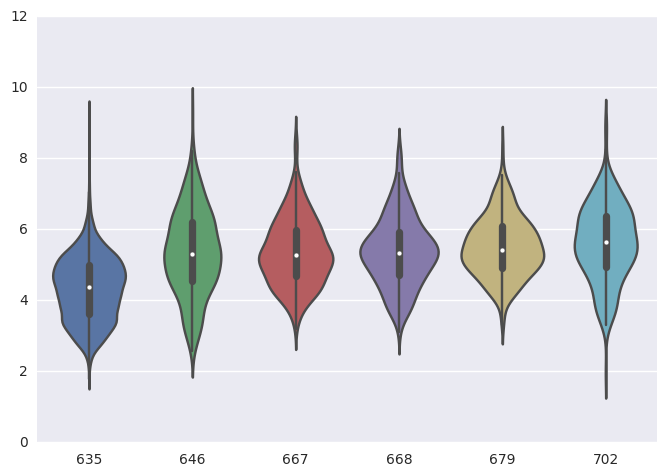

In [4]:
# distribution of log-times
# NOTE: this kind of analysis should be performed on the data without
# the test set to avoid data snooping
sns.violinplot(data=times[[635, 646, 667, 668, 679, 702]])

The dataset contains about 10K of users and 80 tasks.

In [5]:
print('users:', ordering.shape[0])
print('tasks:', ordering.shape[1])
print('interactions:', sum(ordering.count()))

users: 10463
tasks: 70
interactions: 121026


# Interactions

Let's transform the pivoted tables into raw time series of student-task interaction.

In [6]:
def get_events_series():
    data = []
    for user_id in ordering.index:
        order = ordering.loc[user_id].dropna().sort_values()
        for task_id, student_order in order.items():
            event = OrderedDict(
                student_id=int(user_id[2:]),
                student_order=int(student_order),
                task_id=int(task_id),
                time=times.loc[user_id, task_id],
                label=labels.loc[user_id, task_id])
            data.append(event)
    events = pd.DataFrame(data)
    return events

raw_events = get_events_series()
print(raw_events.shape)
raw_events.head()

(121026, 5)


,student_order,label,task_id,time,student_id
0,1,False,635,3.218876,1
1,2,False,636,2.564949,1
2,3,False,656,4.595120,1
3,4,False,698,3.850148,1
4,5,False,638,3.637586,1


# Train-test split

Before doing anything else, we split all interactions into a training set and test set, so that we are able to perform unbiased final evaluation.

We will assume independence between users (which is a reasonable assumption). For a single user, we avoid "predicting past from the future" by a user-stratified split, i.e. we select a random subset of students a puts all their interactions into the test set.

In [11]:
student_ids = pd.Series(raw_events.student_id.unique())
train_student_ids = student_ids.sample(frac=0.7)
train_flags = raw_events.student_id.isin(train_student_ids)
raw_train_events = raw_events[train_flags]
raw_test_events = raw_events[~train_flags]
print('train events:', len(raw_train_events))
print('test events:', len(raw_test_events))

# Create smaller datasets for faster experimentation
raw_train_events = raw_train_events.head(10000)
raw_test_events = raw_test_events.head(5000)

train events: 84342
test events: 36684


# Features

Let us precompute several features, which we will use in the subsequent experiments:

Student-related (skill):
- average student delta from average task time
- number of solved tasks
- ratio of too-difficult interactions
- the most difficult solved task [in ok mode]
- which tasks solved [in which mode] / log-times / quartiles

Task-related (difficulty):
- average/median solving time of the task
- percentage of students who have solved the task
- percentage of too difficult attempts
- mean/median order

(Note: all times are log-scaled).

Steps:
1. To compute task features, use the training set.
2. To compute student featues, use past history of the student in the current evaluation set.

This corresponds to the real-world scenario, in which the task features are preocomputed offline from the historical data, while the student features are computed online, immidiatelly as the student learns.

In [12]:
def compute_task_features(events_train, normalize=False):
    tasks = events_train.groupby('task_id')
    n_students = events_train.student_id.nunique()
    n_tasks = events_train.task_id.nunique()
    task_features = pd.DataFrame(OrderedDict(
      task_time_avg=tasks.time.mean(),
      task_time_med=tasks.time.median(),
      task_unsolved=1 - tasks.time.count() / n_students,
      task_difficult=tasks.label.mean(),
      task_order_avg=tasks.student_order.mean(),
      task_order_med=tasks.student_order.median(),
    ))
    # Note: normalization should be added to the classifier pipeline
    # (student-features derivation requires original features).
    if normalize:
        task_features = pd.DataFrame(
            preprocessing.scale(task_features),
            index=task_features.index,
            columns=task_features.columns)
    return task_features

task_features = compute_task_features(raw_train_events, normalize=False)
task_features.head()

,task_order_avg,task_order_med,task_time_avg,task_unsolved,task_time_med,task_difficult
task_id,,,,,,
635,1.028249,1.0,4.300666,0.020747,4.356709,0.008475
636,2.299843,2.0,2.789894,0.118949,2.564949,0.000000
637,4.404175,3.0,4.127918,0.271093,3.951244,0.011385
638,4.860377,4.0,4.145189,0.266943,4.077537,0.020755
639,17.307692,17.0,5.163710,0.766252,4.997212,0.065089


These precomputed features correlate a lot (see the pair-plot below), which means that it probably won't be much beneficial to use more than one of them.

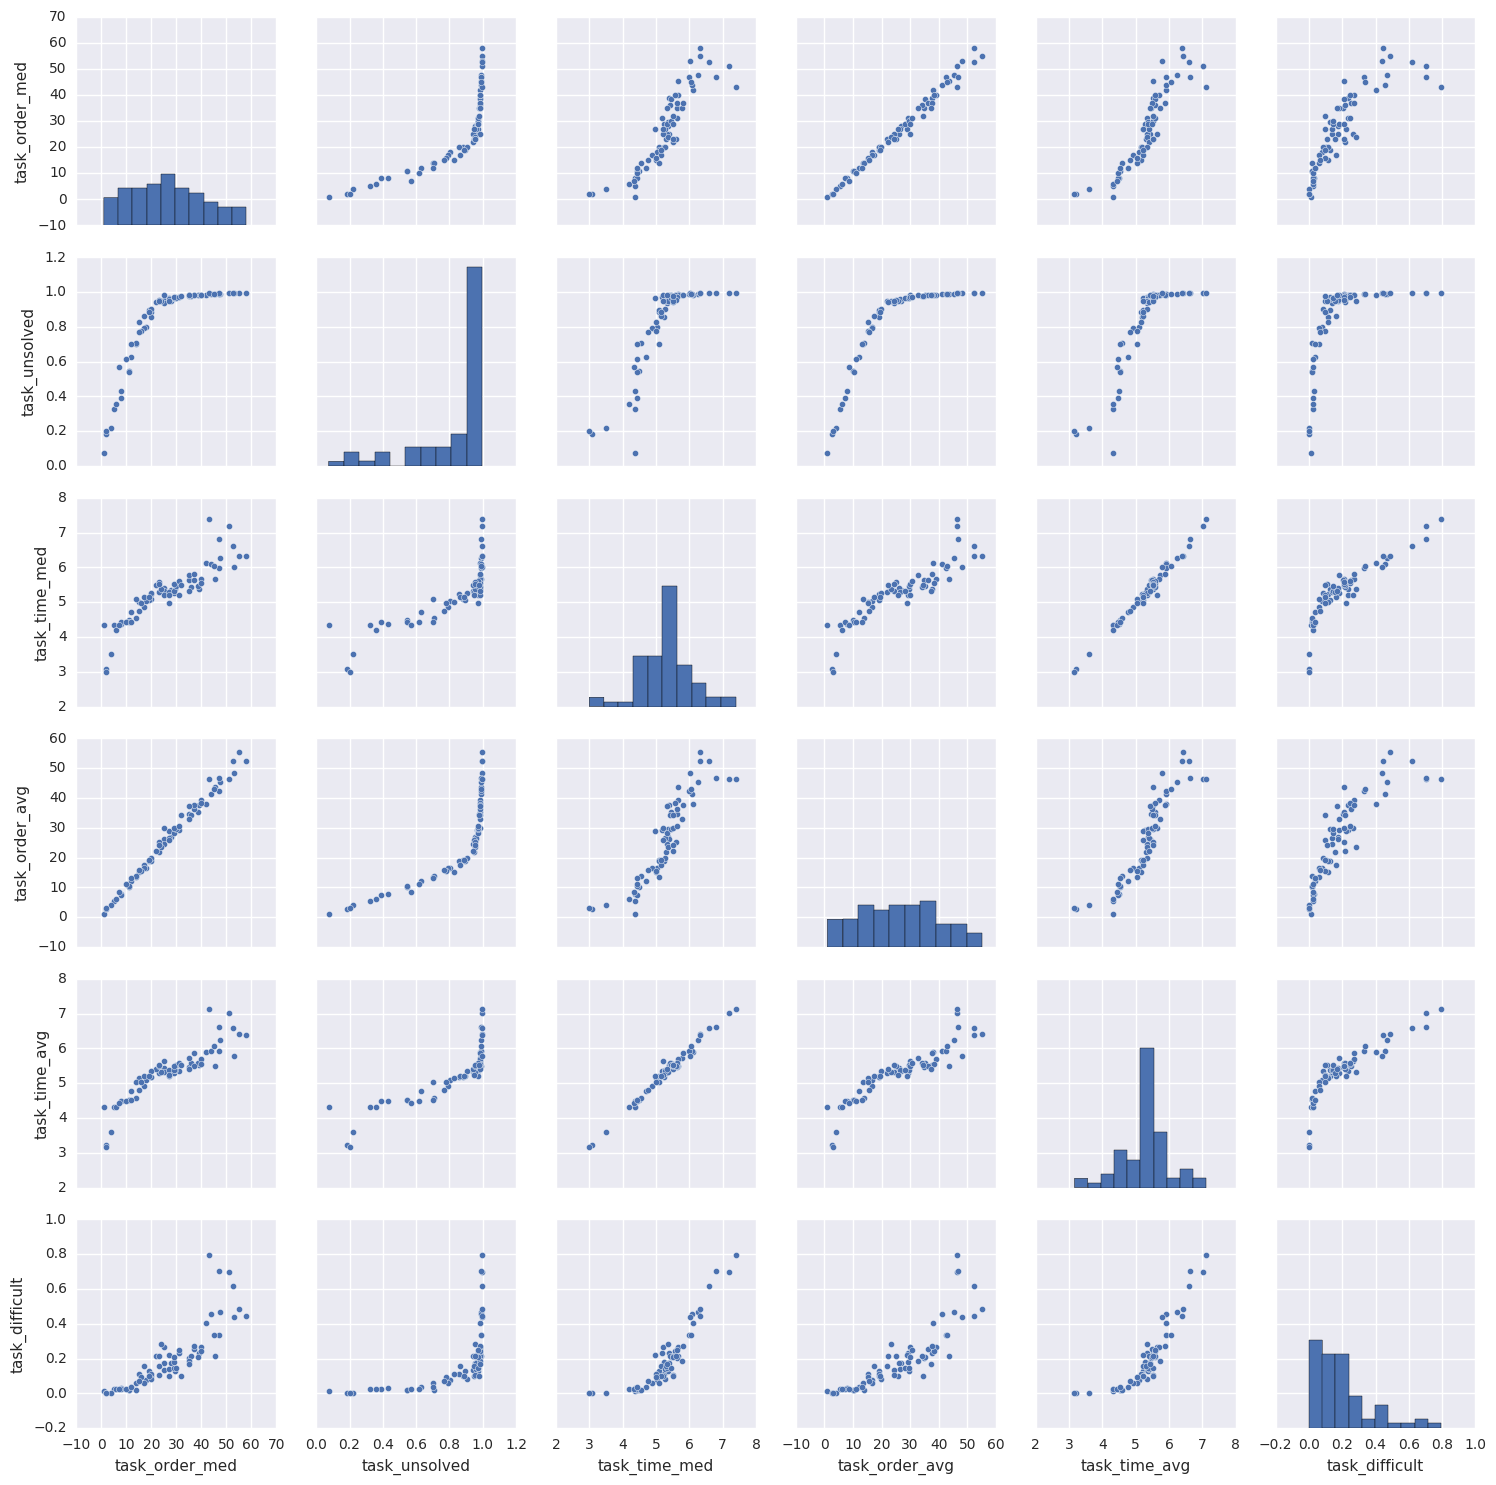

In [10]:
#task_features.task_time_med.plot.hist()
sns.pairplot(task_features)

Now let's derive and join student features:

In [13]:
class Student:
    def __init__(self):
        self.solved_count = 0
        self.timedelta_sum = 0
        self.too_difficult_count = 0
        self.solved = {task_id: 0
                       for task_id in task_features.index}

        
    def update(self, event):
        """Process a single event (with merged task features).
        """
        self.solved_count += 1
        self.solved[event.task_id] = 1
        # For consistency, all student measures are increasing
        # with their skill; hence the positive delta means how much
        # faster they solved the task than is its average time difficulty.
        timedelta = event.task_time_avg - event.time
        self.timedelta_sum += timedelta
        self.too_difficult_count += int(event.label)
        
    @property
    def timedelta_avg(self):
        if self.solved_count == 0:
            return 0
        return self.timedelta_sum / self.solved_count
    
    @property
    def difficult_perc(self):
        if self.solved_count == 0:
            return 0
        return self.too_difficult_count / self.solved_count
        
    @property
    def features(self):
        f = {
            'student_timedelta_avg': self.timedelta_avg,
            'student_difficult_perc': self.difficult_perc,
        }
        for task_id, solved in self.solved.items():
            f['solved_' + str(task_id)] = solved
        return f

def join_task_features(events):
    events = pd.merge(events, task_features, left_on='task_id', right_index=True)
    events.sort_values(by=['student_id', 'student_order'], inplace=True)
    return events  
    
def add_student_features(events):
    """Extend each event features computed "online" for each student.
    """
    students = defaultdict(Student)
    student_features = []
    for i, event in events.iterrows():
        student = students[event.student_id]
        # It's important to append features to the current event
        # BEFORE the student is updated (to avoid cheating).
        student_features.append(student.features)
        student.update(event)
    student_features = pd.DataFrame(student_features, index=events.index)
    return pd.concat([events, student_features], axis=1)


def add_derived_features(events):
    """Extend each event with computed features.
    """
    events = join_task_features(events)
    events = add_student_features(events)
    return events


events_train = add_derived_features(raw_train_events)
events_test = add_derived_features(raw_test_events)
events_train.head(10)

,student_order,label,task_id,time,student_id,task_order_avg,task_order_med,task_time_avg,task_unsolved,task_time_med,...,solved_697,solved_698,solved_700,solved_701,solved_702,solved_703,solved_705,solved_706,student_difficult_perc,student_timedelta_avg
0,1,False,635,3.218876,1,1.028249,1.0,4.300666,0.020747,4.356709,...,0,0,0,0,0,0,0,0,0.0,0.000000
1,2,False,636,2.564949,1,2.299843,2.0,2.789894,0.118949,2.564949,...,0,0,0,0,0,0,0,0,0.0,1.081790
2,3,False,656,4.595120,1,7.022371,6.0,4.512709,0.381743,4.369448,...,0,0,0,0,0,0,0,0,0.0,0.653368
3,4,False,698,3.850148,1,9.295455,8.0,4.529615,0.452282,4.406719,...,0,0,0,0,0,0,0,0,0.0,0.408108
4,5,False,638,3.637586,1,4.860377,4.0,4.145189,0.266943,4.077537,...,0,1,0,0,0,0,0,0,0.0,0.475948
5,6,False,1124,2.639057,1,9.610714,3.0,2.967675,0.612725,2.833213,...,0,1,0,0,0,0,0,0,0.0,0.482279
6,7,False,1120,4.174387,1,13.056034,7.0,4.159118,0.679115,3.839394,...,0,1,0,0,0,0,0,0,0.0,0.456669
7,8,False,1119,5.308268,1,10.064286,4.0,3.430113,0.612725,3.314021,...,0,1,0,0,0,0,0,0,0.0,0.389249
8,9,False,640,6.129050,1,5.541825,5.0,4.278592,0.272476,4.189655,...,0,1,0,0,0,0,0,0,0.0,0.105824
9,10,False,644,4.882802,1,17.223464,17.0,5.133362,0.752420,5.214936,...,0,1,0,0,0,0,0,0,0.0,-0.111541


# Two Features Experiment (avg times)

For the first experiment, I have decied to use only 2 features to allow for plotting the results into 2D plots to gain some intuition. One features is related to the objective task difficulty, one to the student skill:
1. average solving time of the task
2. average student delta from average task time

(Note: all times are log-scaled.)

First, let's see distribution of events wrt. these two features:

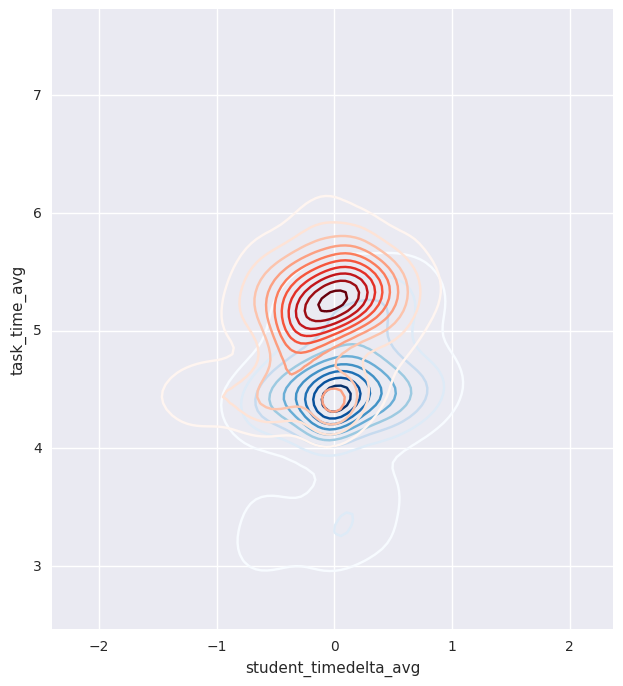

In [12]:
positives = events_train.query("label == True").sample(500)
negatives = events_train.query("label == False").sample(500)

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(
    negatives.student_timedelta_avg,
    negatives.task_time_avg,
    cmap="Blues", shade=False, shade_lowest=False)
ax = sns.kdeplot(
    positives.student_timedelta_avg,
    positives.task_time_avg,
    cmap="Reds", shade=False, shade_lowest=False)

# Add labels to the plot
# red = sns.color_palette("Reds")[-2]
# blue = sns.color_palette("Blues")[-2]
# ax.text(0.2, 0.9, "not-difficult", size=16, color=blue)
# ax.text(0.4, -0.1, "difficult", size=16, color=red)

## Comparing models

goal: compare performance of different models x different features
and explore various evaluation metrics and how much they agree with each other

todo: add evaluation metrics suitable for unbalanced problems

In [81]:
def train_model(model, features):
    X = events_train[features]
    y = events_train.label
    model.fit(X, y)
    return model

def get_test_labels_and_scores(model, features):
    X_test = events_test[features]
    y_test = events_test.label
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:,1]
    else:
        y_scores = model.decision_function(X_test)
    return y_test, y_scores


def get_Xy_test(features):
    X_test = events_test[features].values
    y_test = events_test.label.values
    return X_test, y_test
    

# def eval_model(model, features):
#     X_test = events_test[features]
#     y_test = events_test.label
#     class_predictions = model.predict(X_test)
#     accuracy = np.mean(class_predictions == y_test)
#     return {
#         'accuracy': accuracy
#     }

def evaluate_clf(clf, features):
    """Use training set to cross validate a clf
    """
    X = events_train[features]
    y = events_train.label
    
    cv_results = cross_validate(
        clf, X, y,
        
        # To data snooping ("training on the future data")
        # group-wise CV is used:
        #cv=5,
        cv=GroupKFold(n_splits=5),
        groups=events_train.student_id,
        
        scoring=['accuracy', 'precision', 'recall', 'f1',
                 'roc_auc', 'average_precision'],
        return_train_score=False)
    
#     scores = {
#         'train_accuracy': cv_results['train_accuracy'].mean(),
#         'test_accuracy': cv_results['test_accuracy'].mean(),
#         'train_precision': cv_results['train_precision'].mean(),
#         'test_precision': cv_results['test_precision'].mean(),
#     }

    # filter out _time information
    def shorten(key):
        key = key[5:]
        if key == 'average_precision':
            return 'AP'
        if key == 'roc_auc':
            return 'AUC'
        return key
    
    cv_results = {
        shorten(key): value
        for key, value in cv_results.items()
        if not key.endswith('_time')}
    scores = pd.DataFrame(cv_results)
    return scores

In [15]:
all_features = [
    'task_order_med',
    'task_unsolved',
    'task_time_med',
    'task_order_avg',
    'task_time_avg',
    'task_difficult',
    'student_difficult_perc',
    'student_timedelta_avg',
]

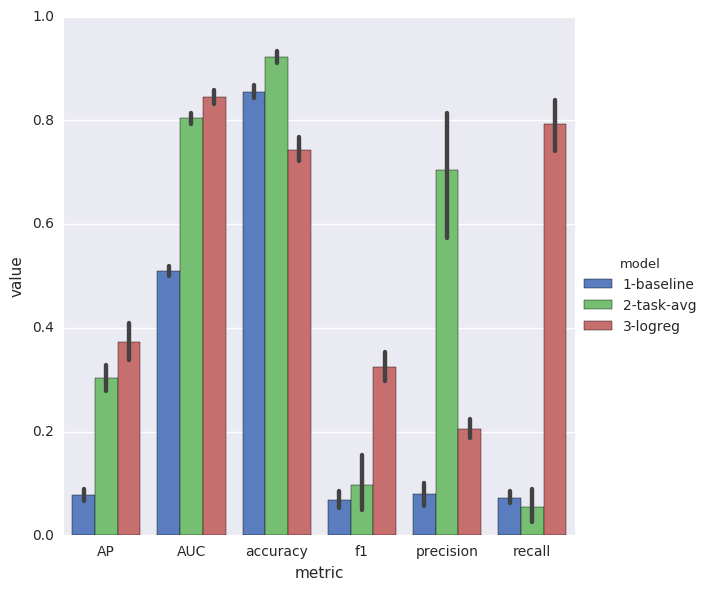

In [82]:
models = [
#     ('constant', DummyClassifier(strategy='most_frequent'),
#      ['student_id']),
    ('1-baseline', DummyClassifier(strategy='stratified'),
      ['student_id']),
     ('2-task-avg', LogisticRegression(),
      ['task_time_avg']),
#     ('student-avg', LogisticRegression(),
#      ['student_timedelta_avg']),
    ('3-logreg', LogisticRegression(class_weight='balanced'),
     ['student_timedelta_avg', 'task_time_avg']),
#     #('perceptron', Perceptron(max_iter=1000, tol=0.0001),
#     ('perceptron', Perceptron(),
#      ['student_timedelta_avg', 'task_time_avg']),
#     ('lda', LinearDiscriminantAnalysis(solver="svd"),
#      ['student_timedelta_avg', 'task_time_avg']),
#     ('qda', QuadraticDiscriminantAnalysis(),
#      ['student_timedelta_avg', 'task_time_avg']),
#     ('svc-weighted', SVC(kernel='linear', class_weight={1: 10}),
#      ['student_timedelta_avg', 'task_time_avg']),
#     ('svc-rbf', SVC(kernel='rbf'),
#      ['student_timedelta_avg', 'task_time_avg']),
#     ('svc-features', SVC(kernel='linear'),
#      all_features),
]

results = {}
for name, model, features in models:
#     model = train_model(model, features)
#     results[name] = eval_model(model, features)
    results[name] = evaluate_clf(model, features)
    #print(name, results[name])

# turn dict of results into a single unpivoted ("long") df
results = pd.concat(results)
results['model'] = results.index.get_level_values(0) 
results = pd.melt(results, id_vars=['model'], var_name='metric')
#results

# show the results
# TODO: group train-test pairs
g = sns.factorplot(
    x='metric', y='value', hue='model', data=results,
    size=6, kind='bar', palette='muted')

In [61]:
best_results = results[results.model == '3-logreg']

# Utils

In [19]:
def show_ap(clf, features):
    clf = train_model(clf, features)
    y_test, y_scores = get_test_labels_and_scores(model, features)
    average_precision = average_precision_score(y_test, y_scores)
    print('AP = {0:0.2f}'.format(average_precision))
    
def plot_pr_curve(clf, features):
    clf = train_model(clf, features)
    y_test, y_scores = get_test_labels_and_scores(clf, features)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve: AP={0:0.2f}'.format(
              average_precision))
    
    p, r, t = precision_recall_curve(y_test, y_scores)
    df = pd.DataFrame({'precision': p[:-1], 'recall': r[:-1], 'threshold': t})
    df.plot(x='threshold')
    
    
def plot_roc_curve(clf, features):
    clf = train_model(clf, features)
    y_test, y_scores = get_test_labels_and_scores(clf, features)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
    df = pd.DataFrame({'fpr': fpr, 'tpr': tpr,
                       'threshold': thresholds})
    df.plot(x='threshold')
    
    
def show_confusion_matrix(clf, features):
    clf = train_model(clf, features)
    y_test, y_scores = get_test_labels_and_scores(clf, features)
    print(confusion_matrix(y_test, y_scores))
    

# Baselines

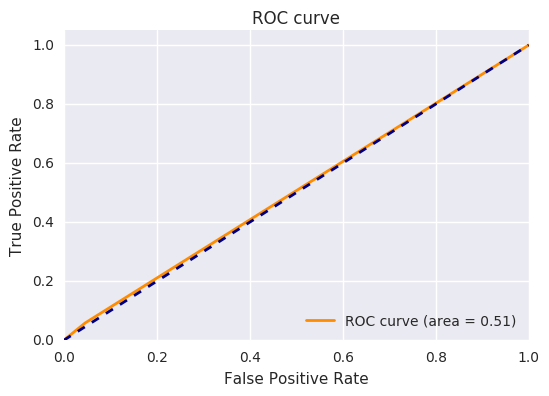

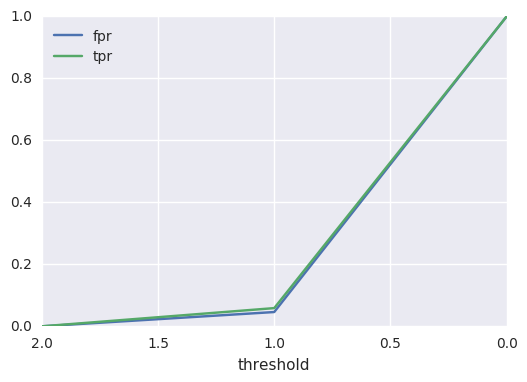

In [119]:
clf = DummyClassifier(strategy='stratified')
#features = ['task_time_avg', 'student_timedelta_avg']
features = ['student_id']
plot_roc_curve(clf, features)

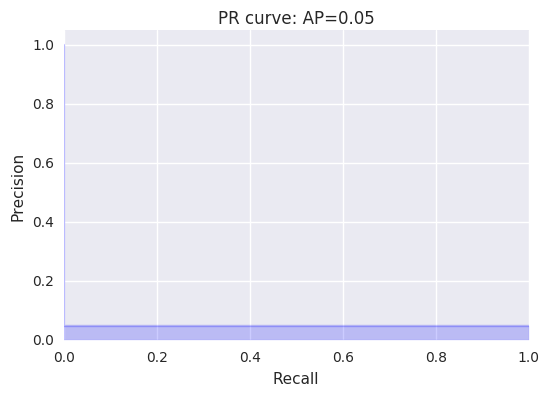

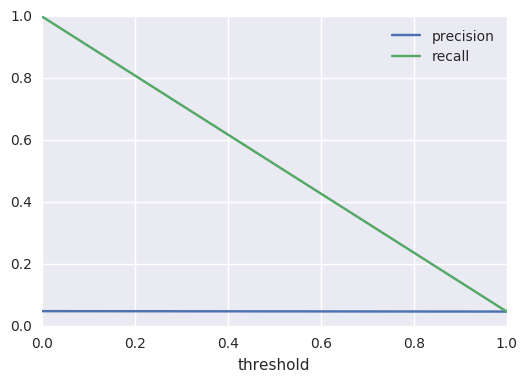

In [120]:
plot_pr_curve(clf, features)

In [122]:
show_confusion_matrix(clf, features)

[[32751  1594]
 [ 1684    85]]


## Logistic Regression

In [14]:
clf = LogisticRegression()
clf = train_model(clf, ['student_timedelta_avg'])
print(clf.intercept_, clf.coef_)
# Both intercpet and skill coeff are negative -> always prediciting not-difficult (same as dummy classifier)

[-2.98162176] [[-0.60819339]]


In [15]:
clf = LogisticRegression()
clf = train_model(clf, ['task_time_avg'])
print(clf.intercept_, clf.coef_)

[-12.89043767] [[ 2.07621862]]


In [16]:
clf = LogisticRegression()
clf = train_model(clf, ['task_time_avg', 'student_timedelta_avg'])
print(clf.intercept_, clf.coef_)

[-14.37663093] [[ 2.37337548 -1.36130962]]


We want penalize false negatives more than false positives - it's ok to lock some not-difficult tasks, it's bad not to lock too dificult tasks. [not clear] So recall (sensitivity) is more imporatant than precision.

First step: measure recall, precision, auc-pr

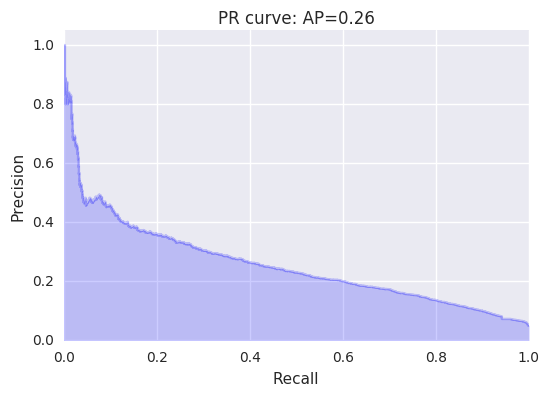

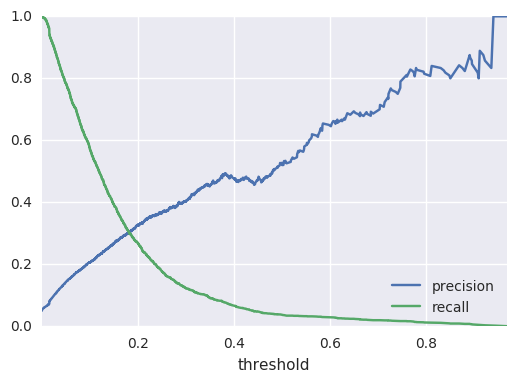

In [80]:
clf = LogisticRegression()
features = ['task_time_avg', 'student_timedelta_avg']
plot_pr_curve(clf, features)

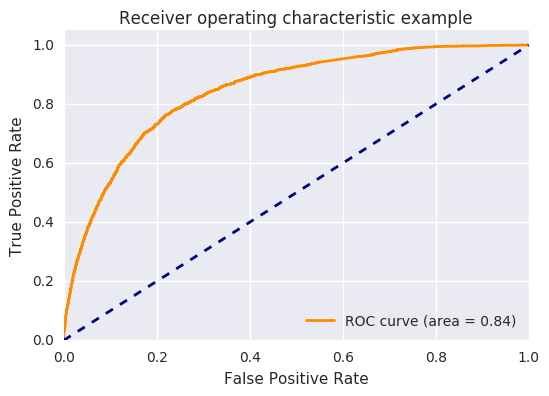

In [81]:
plot_roc_curve(clf, features)

# SVM

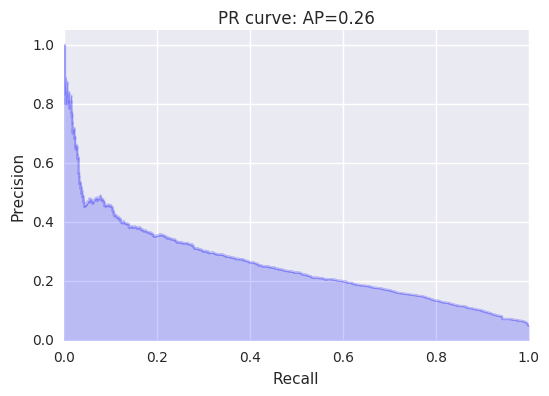

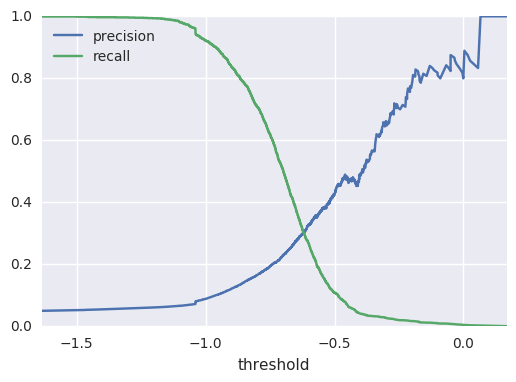

In [82]:
clf = LinearSVC()
features = ['task_time_avg', 'student_timedelta_avg']
plot_pr_curve(clf, features)

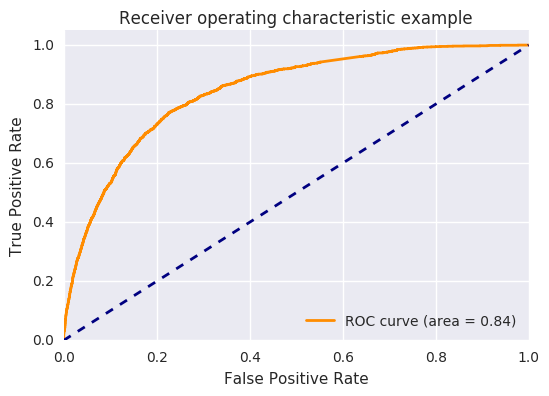

In [83]:
plot_roc_curve(clf, features)

# Class Weighting

In [142]:
features = ['task_time_avg', 'student_timedelta_avg']
X, y = get_Xy_test(features)
# ------------------------------------------------
# SVC with class-weights
# source: http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html
# ------------------------------------------------
clf = SVC(kernel='linear', C=1.0)
clf.fit(X, y)

# fit the model and get the separating hyperplane using weighted classes
wclf = SVC(kernel='linear', class_weight={1: 10})
wclf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight={1: 10}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

/home/tom/.virtualenvs/flocs-analyses/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


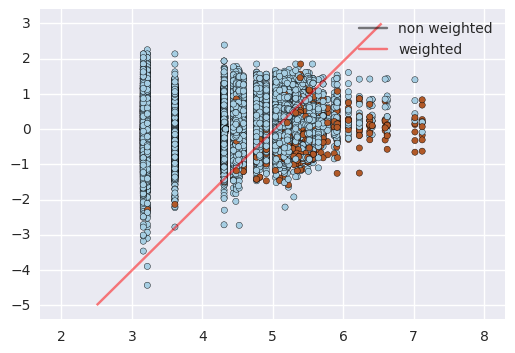

In [143]:
# plot separating hyperplanes and samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
plt.legend()

# plot the decision functions for both classifiers
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# get the separating hyperplane
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
a = ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

# get the separating hyperplane for weighted classes
Z = wclf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins for weighted classes
b = ax.contour(XX, YY, Z, colors='r', levels=[0], alpha=0.5, linestyles=['-'])

plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],
           loc="upper right")
plt.show()

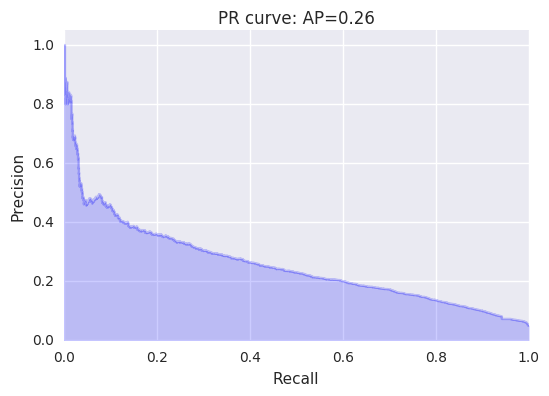

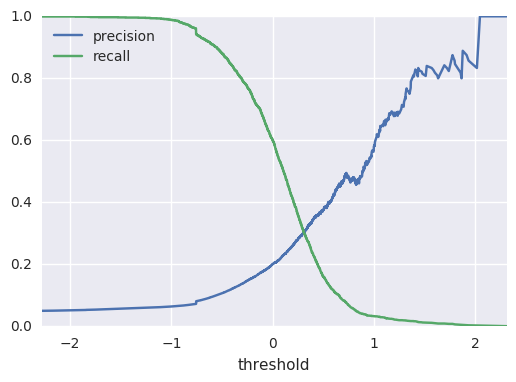

In [151]:
# class weights only influence final decision threshold,
# so the PR curve is same:
clf = LinearSVC(class_weight={1: 10})
features = ['task_time_avg', 'student_timedelta_avg']
plot_pr_curve(clf, features)

# Using more features

Precision~0.2 @ recall~0.5

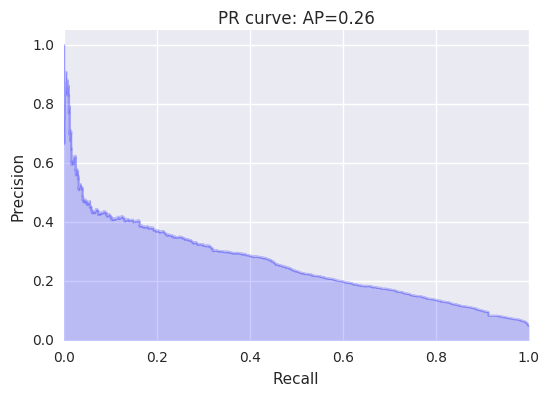

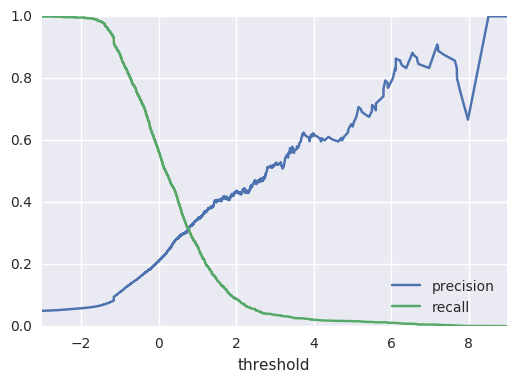

In [150]:
clf = SVC(kernel='linear', class_weight={1: 10})
plot_pr_curve(clf, all_features)

# RBF kernel

Didn't helped, took ages.

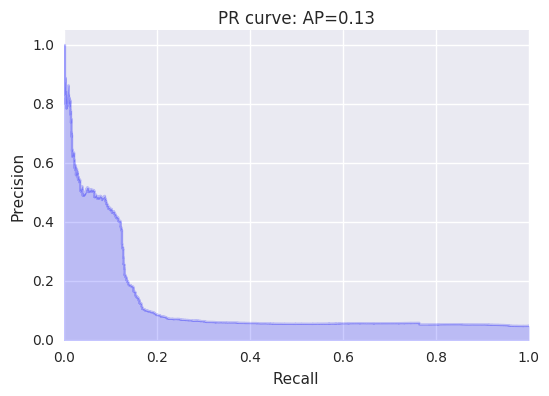

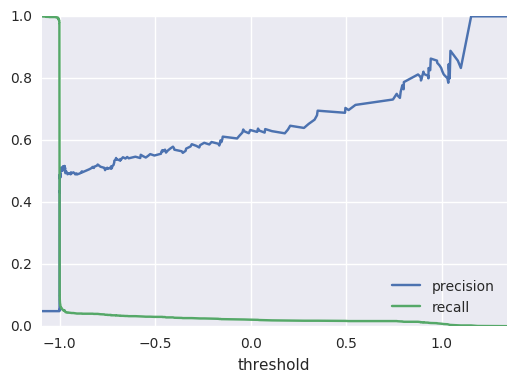

In [149]:
clf = SVC(kernel='rbf')
plot_pr_curve(clf, all_features)

# Tasks as features

Idea: use info about solved tasks as features

Result: no significant improvement (see below)

In [20]:
all_features2 = all_features \
    + ['solved_' + str(task_id) for task_id in task_features.index]

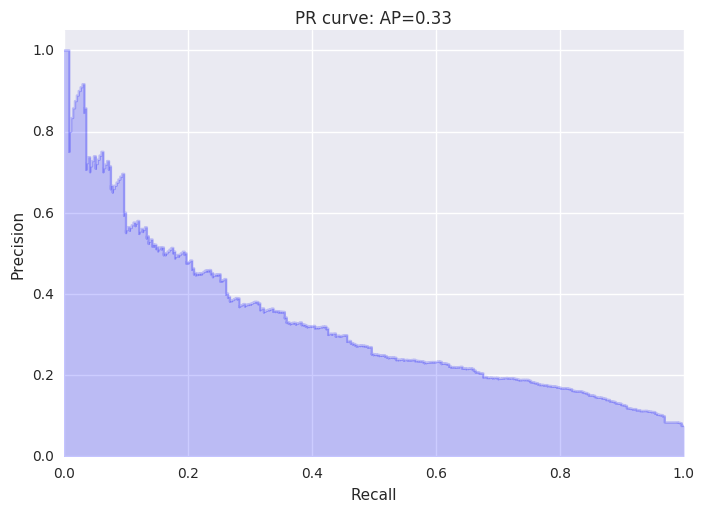

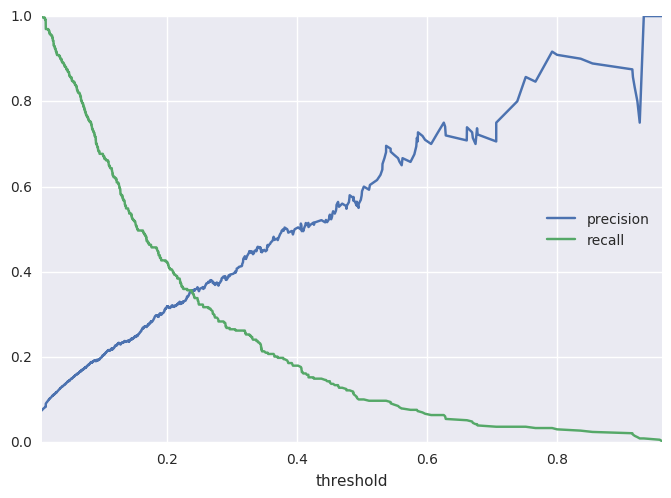

In [22]:
clf = LogisticRegression()
#clf = LinearSVC(class_weight={1: 10})
plot_pr_curve(clf, all_features2)

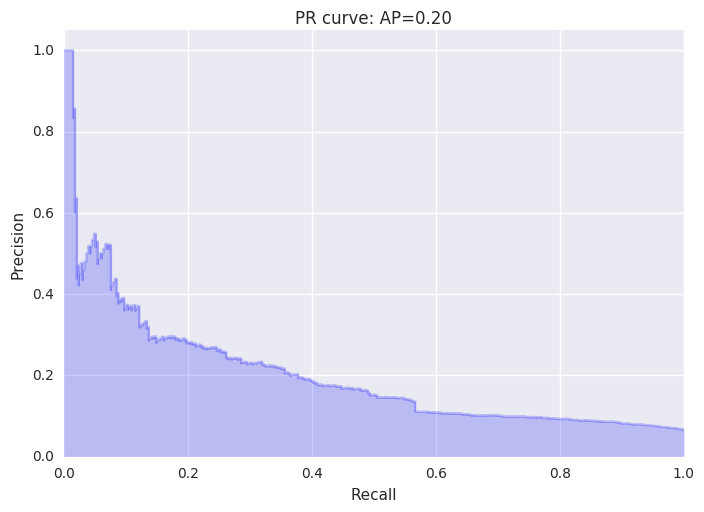

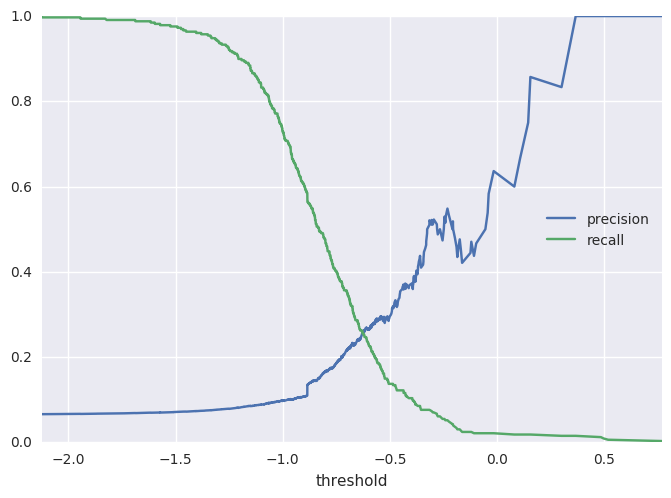

In [23]:
clf = LinearSVC(class_weight={1: 10})
plot_pr_curve(clf, all_features2)

# Feature Selection

As we have seen, task features seems to correlate a lot + we have included a feature for each task - many of them may not be informative -> feature selection could help.

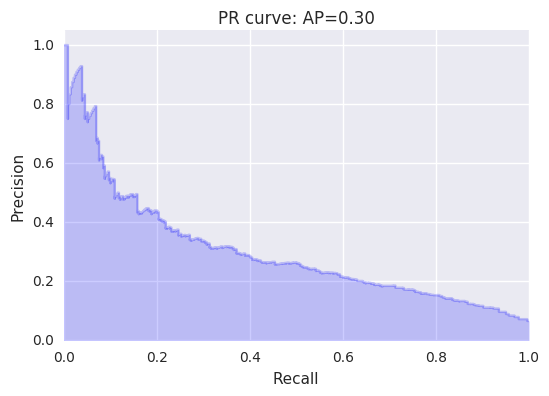

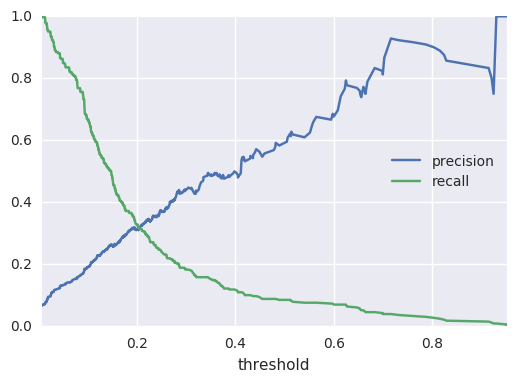

In [33]:
remove_constant = feature_selection.VarianceThreshold()
transform = feature_selection.SelectPercentile(
    feature_selection.f_classif,
    percentile=20)
clf = Pipeline([
    ('remove-constant', remove_constant),
    ('anova', transform),
    #('svc', LinearSVC())])
    ('log-reg', LogisticRegression())])
plot_pr_curve(clf, all_features2)

The below compuation illustarates, how can find a good value for percentile of features to keep:

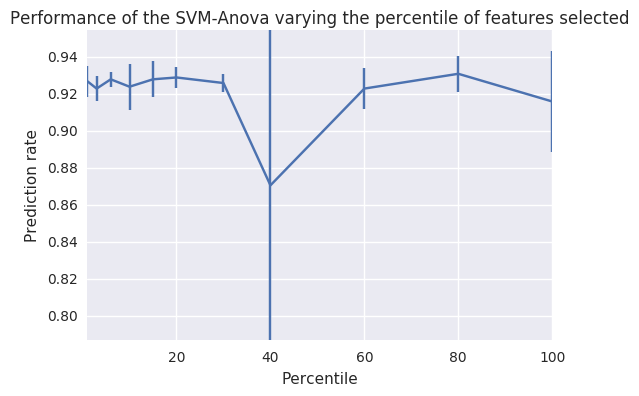

In [30]:
X, y = get_Xy_test(all_features2)
X = X[:1000]
y = y[:1000]
# ------------------------------------------------
# SVC with feature selection
# source: http://scikit-learn.org/stable/auto_examples/svm/plot_svm_anova.html#sphx-glr-auto-examples-svm-plot-svm-anova-py
# ------------------------------------------------
# #############################################################################
# Create a feature-selection transform and an instance of SVM that we
# combine together to have an full-blown estimator

remove_constant = feature_selection.VarianceThreshold()
transform = feature_selection.SelectPercentile(
    feature_selection.f_classif)
clf = Pipeline([
    ('remove-constant', remove_constant),
    ('anova', transform),
    ('svc', LinearSVC())])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()


# Final Evaluation


- take the best classifier + best threshold (using CV)
- confusion matrix
- evaluation incl. CI (95%): FPR, TPR etc. (using normal approx.)
- ROC curve, AUC
- PR curve, AP + conf.intervals (via repeated trial in CV)
- compare to baseline

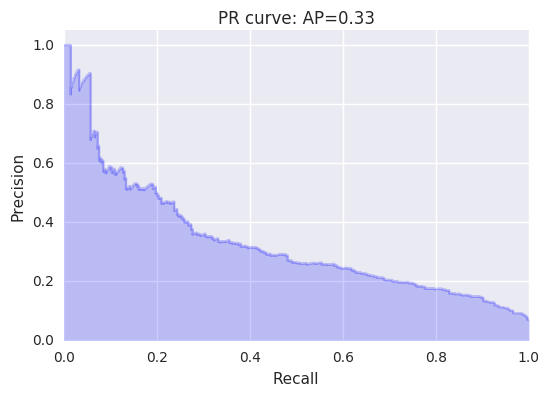

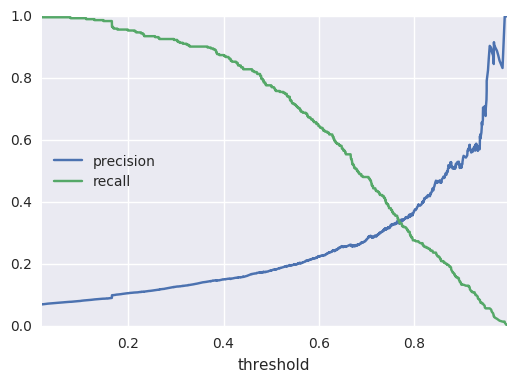

In [39]:
# best model (TODO: replace by the best)
clf = LogisticRegression(class_weight='balanced')
features = ['task_time_avg', 'student_timedelta_avg']
plot_pr_curve(clf, features)

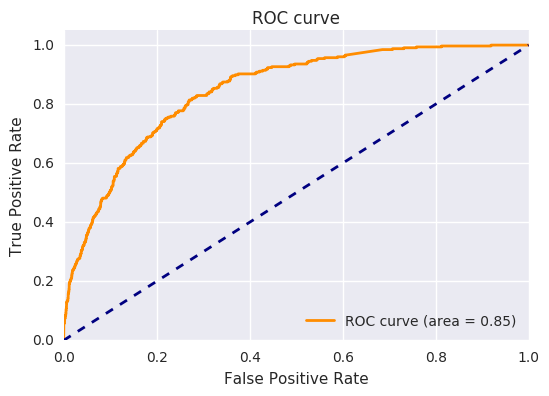

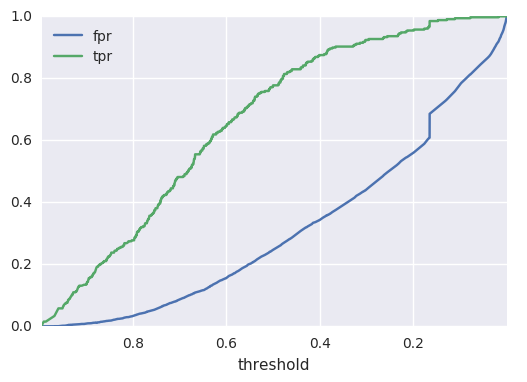

In [40]:
plot_roc_curve(clf, features)

In [85]:
clf = train_model(clf, features)
X, y = get_Xy_test(features)
yp = clf.predict(X)
print(confusion_matrix(y, yp) / np.sum(confusion_matrix(y, yp)))

[[ 0.7038  0.2306]
 [ 0.0146  0.051 ]]


In [43]:
from sklearn.metrics import classification_report
print(classification_report(y, yp))

             precision    recall  f1-score   support

      False       0.98      0.75      0.85      4672
       True       0.18      0.78      0.29       328

avg / total       0.93      0.75      0.82      5000



In [46]:
tn, fp, fn, tp = confusion_matrix(y, yp).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
# TPR & FPR = sensitivity & 1-specificity = recall for 1/0 (above)
tpr, fpr

(0.77743902439024393, 0.24678938356164384)

In [50]:
# TPV, FPV = same as preicison of 1/0 (as above)
tpv = tp / (tp + fp)
fpv = tn / (tn + fn)
tpv, fpv

(0.18110795454545456, 0.97967706013363032)

In [44]:
from scipy import stats
from scipy.stats import norm

def prop_CI(p, n, alpha=0.05):      
    ci_lo = ci_hi = 0.0    
    # normal approximation for binomial CIs
    z = norm.ppf(1-alpha/2)  # quantile
    ci_lo = p - z*np.sqrt(p*(1-p)/n)
    ci_hi = p + z*np.sqrt(p*(1-p)/n)     
    return ci_lo, ci_hi

In [51]:
print("TPR: 95% CI =", prop_CI(tpr, n=tp+fn), "(normal apprx.)")
print("FPR: 95% CI =", prop_CI(fpr, n=fp+tn), "(normal apprx.)")
print("TPV: 95% CI =", prop_CI(tpv, n=tp+fp), "(normal apprx.)")
print("FPV: 95% CI =", prop_CI(fpv, n=tn+fn), "(normal apprx.)")

TPR: 95% CI = (0.73242282293116101, 0.82245522584932684) (normal apprx.)
FPR: 95% CI = (0.23442654702625695, 0.25915222009703071) (normal apprx.)
TPV: 95% CI = (0.16099254622579728, 0.20122336286511183) (normal apprx.)
FPV: 95% CI = (0.97506266625576077, 0.98429145401149987) (normal apprx.)


In [83]:
# confidence intervals for CV above
df = best_results
ap = df[df.metric == 'test_average_precision'].value
z = 1.96
print('AP = ', ap.mean(), '+-', z * ap.std())
auc = df[df.metric == 'test_roc_auc'].value
print('AUC = ', auc.mean(), '+-', z * auc.std())

AP =  0.371396334102 +- 0.144034980469
AUC =  0.847728539838 +- 0.0396321035169


In [89]:
0.848 + 0.039

0.887

## Perceptron

In [27]:
# # original experiment with different features
# model = Perceptron(max_iter=1000, tol=0.0001, fit_intercept=True)
# features = ['student_solved_percentage', 'task_solved_percentage']
# train_model(model, features)
# print(eval_model(model, features))
# print('Weights:', model.coef_)
# print('Intercept:', model.intercept_)

Observations:
* Feature `task_solved_percentage` is 7-times more important than `student_solved_percentage`.
* The fact that the student has solved more tasks is positively correlated with the task beign labeled as too difficult. This is proably caused by the *self-selection bias*: students with more solved tasks attempt tasks at the end of the list, and these tasks are more time consuming. So this result suggests that the `student_solved_percentage` is a dangerour feauture and should not be used.

In [28]:
clf = Perceptron(max_iter=10000, tol=0.00001, fit_intercept=True)
features = ['student_timedelta_avg', 'task_time_avg']
train_model(clf, features)
print(eval_model(clf, features))
print('Weights:', clf.coef_)
print('Intercept:', clf.intercept_)

{'accuracy': 0.68208714362560519}
Weights: [[-10.25465427  20.22007572]]
Intercept: [-93.]


Text(0.5,1,'Perceptron')

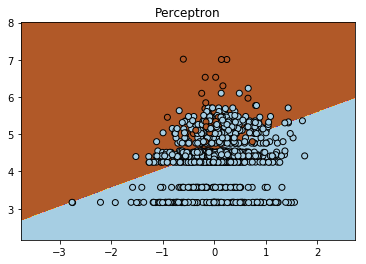

In [29]:
# Plot decision boundary
# Source: https://stats.stackexchange.com/questions/71335/decision-boundary-plot-for-a-perceptron
some_events = events_train.sample(1000)
X = some_events[features].values
y = some_events.label.values
h = 0.02
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
fig, ax = plt.subplots()
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

ax.set_title('Perceptron')

## LDA and QDA

FDA = LDA for 2 classes (?)

In [30]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
features = ['student_timedelta_avg', 'task_time_avg']
train_model(lda, features)
print(eval_model(lda, features))

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
train_model(qda, features)
print(eval_model(qda, features))

{'accuracy': 0.95783703476011173}
{'accuracy': 0.9579138809908041}


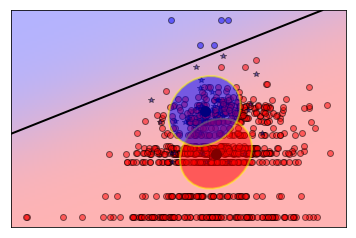

In [31]:
# plots (X and y taken from the previeous section)
# taken from scikit-learn http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html) 

from scipy import linalg
from matplotlib import colors
import matplotlib as mpl
# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)
# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred):
    splot = plt.subplot()
    
    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')


y_pred = lda.predict(X)
splot = plot_data(lda, X, y, y_pred)
plot_lda_cov(lda, splot)

/home/xeffenb1/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)
/home/xeffenb1/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute covariances_ was deprecated in version 0.19 and will be removed in 0.21. Use covariance_ instead
  warnings.warn(msg, category=DeprecationWarning)


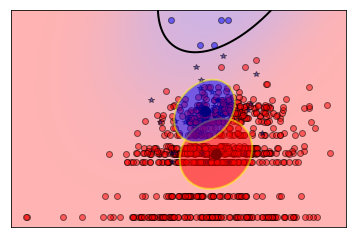

In [32]:
y_pred = qda.predict(X)
splot = plot_data(qda, X, y, y_pred)
plot_qda_cov(qda, splot)

# Failures and Lessons Learned

### Beware of Self-Selection Bias

In the first experiment, I used the following 2 featues:
1. how many tasks has the student already solved (student_solved_percentage)
2. how many students have solved the task (task_solved_percentage)

Due to self-selection bias, student_solved_percentage correlated positively with too difficult task. As a result, the more the student solved, the more "too dificult" predictions he would obtain, which doesn't make sense.


### Don't Use Accuracy and AUC for Unbalanced Problems

For unbalanced problems, these are nearly 1 for the majority-class predictors, which are useless. Metrics derived from the confusion metrics (true/false positive rate, positive/negative predictive power and their combinations) need to be considered.